In [10]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup

In [2]:
train_df = pd.read_csv("data/twitter_data_train_multiclass.csv")
test_df = pd.read_csv("data/twitter_data_test_multiclass.csv")

print(train_df.shape)
print(test_df.shape)

(9446, 238)
(1667, 238)


### LSTM and RNN On Account's Description Text

In [3]:
train = train_df[['description_processed','tweets_list_processed', 'account_type_multi']]
test = test_df[['description_processed','tweets_list_processed','account_type_multi']]

train['description_processed'] = train['description_processed'].apply(str)
test['description_processed'] = test['description_processed'].apply(str)

C:\Users\radellng\AppData\Local\Temp\ipykernel_15824\1025729854.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['description_processed'] = train['description_processed'].apply(str)
C:\Users\radellng\AppData\Local\Temp\ipykernel_15824\1025729854.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['description_processed'] = test['description_processed'].apply(str)


In [4]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 128

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train['description_processed'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

tokenizer_test = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer_test.fit_on_texts(test['description_processed'].values)
word_index_test = tokenizer_test.word_index
print('Found %s unique tokens.' % len(word_index_test))

Found 16349 unique tokens.
Found 4366 unique tokens.


In [5]:
X = tokenizer.texts_to_sequences(train['description_processed'].values)
X_train = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train.shape)

x = tokenizer_test.texts_to_sequences(test['description_processed'].values)
X_test = pad_sequences(x, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_test.shape)

Shape of data tensor: (9446, 250)
Shape of data tensor: (1667, 250)


In [6]:
y_train = to_categorical(train['account_type_multi'], num_classes=6)
y_test = to_categorical(test['account_type_multi'], num_classes=6)

print(y_train.shape)
print(y_test.shape)

(9446, 6)
(1667, 6)


In [7]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 128)          6400000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 6,449,798
Trainable params: 6,449,798
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
epochs = 10
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
133/133 [==============================] - 73s 526ms/step - loss: 1.2587 - accuracy: 0.4815 - val_loss: 1.0355 - val_accuracy: 0.5735
Epoch 2/10
133/133 [==============================] - 70s 529ms/step - loss: 0.9934 - accuracy: 0.5998 - val_loss: 0.9418 - val_accuracy: 0.6085
Epoch 3/10
133/133 [==============================] - 69s 520ms/step - loss: 0.9129 - accuracy: 0.6397 - val_loss: 0.9013 - val_accuracy: 0.6487
Epoch 4/10
133/133 [==============================] - 69s 521ms/step - loss: 0.8282 - accuracy: 0.6925 - val_loss: 0.8734 - val_accuracy: 0.6550
Epoch 5/10
133/133 [==============================] - 71s 535ms/step - loss: 0.7560 - accuracy: 0.7253 - val_loss: 0.8648 - val_accuracy: 0.6593
Epoch 6/10
133/133 [==============================] - 71s 533ms/step - loss: 0.6952 - accuracy: 0.7557 - val_loss: 0.8398 - val_accuracy: 0.6836
Epoch 7/10
133/133 [==============================] - 71s 532ms/step - loss: 0.6528 - accuracy: 0.7737 - val_loss: 0.8698 - val_ac

In [12]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
print(classification_report(test['account_type_multi'], pred, digits=5))

53/53 [==============================] - 2s 36ms/step - loss: 1.4974 - accuracy: 0.5657
Test set
  Loss: 1.497
  Accuracy: 0.566
53/53 [==============================] - 2s 34ms/step
              precision    recall  f1-score   support

           0    0.47156   0.62228   0.53653       413
           1    0.44762   0.20435   0.28060       460
           2    0.00000   0.00000   0.00000        58
           3    0.64912   0.88889   0.75032       666
           4    0.00000   0.00000   0.00000        53
           5    0.00000   0.00000   0.00000        17

    accuracy                        0.56569      1667
   macro avg    0.26138   0.28592   0.26124      1667
weighted avg    0.49968   0.56569   0.51012      1667



C:\Users\radellng\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\radellng\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\radellng\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


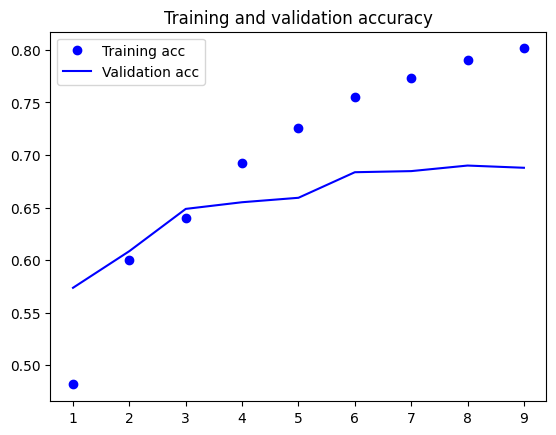

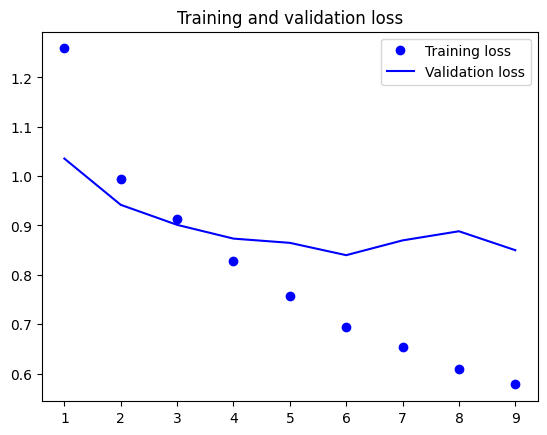

In [13]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### LSTM and RNN On Account's Tweets Text

In [14]:
train['tweets_list_processed'] = train['tweets_list_processed'].apply(str)
test['tweets_list_processed'] = test['tweets_list_processed'].apply(str)

tweet_tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tweet_tokenizer.fit_on_texts(train['tweets_list_processed'].values)
tweet_word_index = tweet_tokenizer.word_index
print('Found %s unique tokens.' % len(tweet_word_index))

tweet_tokenizer_test = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tweet_tokenizer_test.fit_on_texts(test['tweets_list_processed'].values)
tweet_word_index_test = tokenizer_test.word_index
print('Found %s unique tokens.' % len(tweet_word_index_test))


C:\Users\radellng\AppData\Local\Temp\ipykernel_15824\866718681.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['tweets_list_processed'] = train['tweets_list_processed'].apply(str)
C:\Users\radellng\AppData\Local\Temp\ipykernel_15824\866718681.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['tweets_list_processed'] = test['tweets_list_processed'].apply(str)


Found 1290669 unique tokens.
Found 4366 unique tokens.


In [15]:
X_tweets = tweet_tokenizer.texts_to_sequences(train['tweets_list_processed'].values)
X_train_tweets = pad_sequences(X_tweets, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train_tweets.shape)

x_tweets = tweet_tokenizer_test.texts_to_sequences(test['tweets_list_processed'].values)
X_tweets_test = pad_sequences(x_tweets, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_tweets_test.shape)

Shape of data tensor: (9446, 250)
Shape of data tensor: (1667, 250)


In [16]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train_tweets.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
epochs = 10
batch_size = 64

history = model.fit(X_train_tweets, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 128)          6400000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 250, 128)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 6,449,798
Trainable params: 6,449,798
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
133/133 [==============================] - 64s 463ms/step - loss: 1.3051 - accuracy: 0.4192 - 

In [17]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
print(classification_report(test['account_type_multi'], pred, digits=5))

53/53 [==============================] - 2s 40ms/step - loss: 1.8595 - accuracy: 0.4115
Test set
  Loss: 1.860
  Accuracy: 0.412
53/53 [==============================] - 2s 39ms/step
              precision    recall  f1-score   support

           0    0.26687   0.21065   0.23545       413
           1    0.35860   0.42174   0.38761       460
           2    0.00000   0.00000   0.00000        58
           3    0.54582   0.60811   0.57528       666
           4    0.00000   0.00000   0.00000        53
           5    0.00000   0.00000   0.00000        17

    accuracy                        0.41152      1667
   macro avg    0.19521   0.20675   0.19972      1667
weighted avg    0.38314   0.41152   0.39513      1667



C:\Users\radellng\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\radellng\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\radellng\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


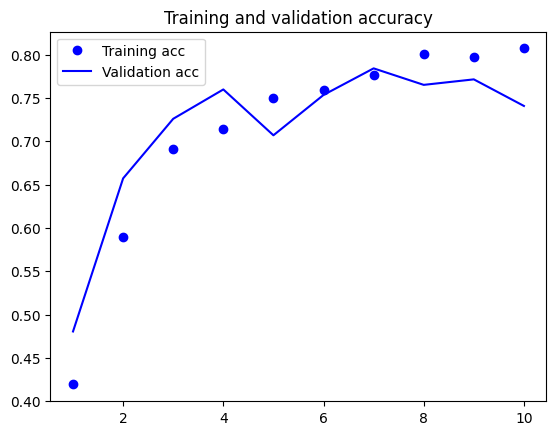

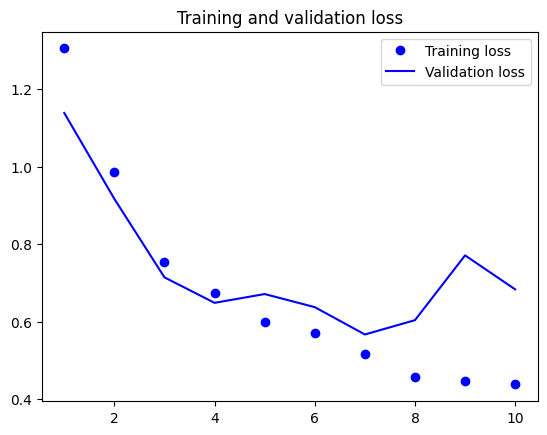

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()